# Asteroid Data Analyses

In [235]:
import psycopg2
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
from mpl_toolkits.mplot3d import Axes3D

In [174]:
#Connecting to the engine and retriving data
engine = create_engine('postgresql://akshen:da@123@127.0.0.1:5432/asteroids')
rnvdf = pd.read_sql_table('asteroid_data', engine)
apvf = pd.read_sql_table('asteroids_potential_value', engine)
loeadf = pd.read_sql_table('loea_largest_by_diameter', engine)

In [175]:
rnvdf.shape

(843784, 8)

In [176]:
rnvdf.columns
rnvdf.drop(rnvdf.columns[1], axis=1, inplace=True)
rnvdf.head(5)

,index,full_name,neo,moid_jup,moid,producer,rot_per
0,0,1 Ceres,N,2.09753,1.59478,Davide Farnocchia,9.074170
1,1,2 Pallas,N,1.85493,1.23324,Otto Matic,7.813200
2,2,3 Juno,N,2.18657,1.03454,Otto Matic,7.210000
3,3,4 Vesta,N,2.46988,1.13948,Davide Farnocchia,5.342128
4,4,5 Astraea,N,1.96040,1.09589,Otto Matic,16.806000


# Identifying Potential Hazardous Asteroids 
#### An object is classified as a potentially hazardous object (PHO) – that is, posing a possible risk to Earth – if, among other conditions, its Earth MOID is less than 0.05 AU.
> A low MOID does not mean that a collision is inevitable as the planets frequently perturb the orbit of small bodies. It is also necessary that the two bodies reach that point in their orbits at the same time before the smaller body is perturbed into a different orbit with a different MOID value. Two Objects gravitationally locked in orbital resonance may never approach one another.

In [177]:
mean_v = rnvdf['moid'].mean()
rnvdf['moid'].fillna(mean_v, inplace=True)
pha = []
for i, row in rnvdf.iterrows():
     pha.append('Y' if float(row[4]) < 0.05 else 'N')
rnvdf['pha'] = pha
rnvdf['pha'].value_counts()

N    833421
Y     10363
Name: pha, dtype: int64

<IPython.core.display.Javascript object>


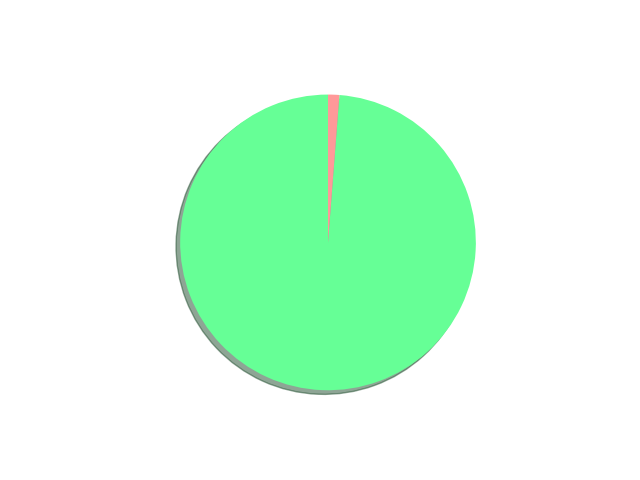

([<matplotlib.patches.Wedge at 0x162cdbdd0>,
 [Text(-0.04243162135262061, -1.099181312390903, ''),
  Text(0.0424316824570853, 1.0991813100320897, '')])

In [178]:
colors = ['#66ff96','#ff9999']
plt.pie(rnvdf['pha'].value_counts(), colors=colors,
       shadow=True, startangle=90)

In [179]:
rnvdf['neo_pha'] = (rnvdf.neo == 'Y') & (rnvdf.pha == 'Y')

In [180]:
rnvdf['neo_pha'].value_counts()

False    833447
True      10337
Name: neo_pha, dtype: int64

In [181]:
rnvdf.loc[rnvdf['moid'].idxmin()]

index                    649226
full_name           (2011 KE15)
neo                           Y
moid_jup                2.75136
moid                3.43764e-07
producer             Otto Matic
rot_per                     NaN
pha                           Y
neo_pha                    True
Name: 649226, dtype: object

<IPython.core.display.Javascript object>


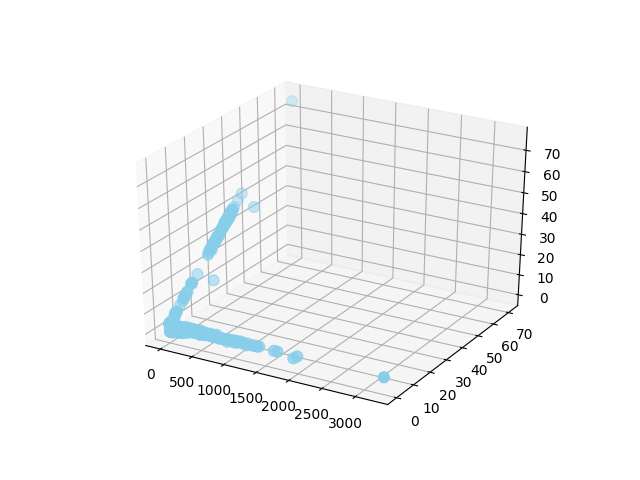

In [182]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rnvdf['rot_per'],rnvdf['moid_jup'],rnvdf['moid'],s=60,c='skyblue',marker='o')
plt.show()

In [194]:
loeadf = loeadf.rename(columns={"Name": "full_name"}) 
rnvdf['full_name']= rnvdf.full_name.str.strip()

In [210]:
merge = pd.merge(left=rnvdf, right=loeadf, left_on='full_name', right_on='full_name')
merge.head()

,index_x,full_name,neo,moid_jup,moid,producer,rot_per,pha,neo_pha,index_y,Diameter_in_km_geometric_mean,Dimension_in_km,Mean distance from Sun_in_AU,Date discovered,Discoverer,Class
0,0,1 Ceres,N,2.09753,1.594780,Davide Farnocchia,9.074170,N,False,0,939.4±0.2,964.4 × 964.2 × 891.8,2.766,"January 1, 1801","Piazzi, G.",G
1,1,2 Pallas,N,1.85493,1.233240,Otto Matic,7.813200,N,False,2,512±3,550±4 × 516±3 × 476±3 km[2],2.773,"March 28, 1802","Olbers, H. W.",B
2,2,3 Juno,N,2.18657,1.034540,Otto Matic,7.210000,N,False,10,258,320×267×200,2.672,"September 1, 1804","Harding, K. L.",S
3,3,4 Vesta,N,2.46988,1.139480,Davide Farnocchia,5.342128,N,False,1,525.4±0.2,572.6 × 557.2 × 446.4 ± 0.2,2.362,"March 29, 1807","Olbers, H. W.",V
4,5,6 Hebe,N,2.63580,0.973965,Otto Matic,7.274500,N,False,33,186,205x185x170,2.426,"July 1, 1847","Hencke, K. L.",S


<IPython.core.display.Javascript object>


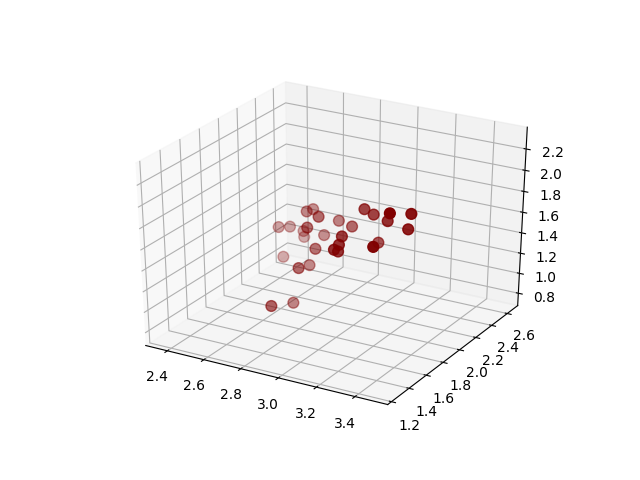

In [209]:
figg = plt.figure()
axx = figg.add_subplot(111, projection='3d')
axx.scatter(merge['Mean distance from Sun_in_AU'],merge['moid_jup'],merge['moid'],s=60,c='maroon',marker='o')
plt.show()

In [331]:
freq = dict(merge['Class'].value_counts())
#for x, y in freq.items():  freq[x] = [y]
freq = pd.DataFrame(list(freq.items()), columns=['Class', 'Count'])
figure = px.bar(freq,x="Class", y="Count", color=[
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
])
figure.update_layout(showlegend=False)